In [515]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [516]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas as gpd
from matplotlib import cm
%matplotlib inline

In [517]:
df = pd.read_csv('opportunities.csv',low_memory=False)

Top 10 localidades con mayor cantidad de oportunidades Closed Won


---



In [518]:
df_closed_won = df[df['Stage'] == 'Closed Won']
df_closed_won = df_closed_won[df_closed_won['Stage'] != None]
df_closed_won = df_closed_won.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_closed_won = df_closed_won.rename(columns={"Stage": "number_of_closed_wons"})
df_closed_won = df_closed_won.sort_values(by='number_of_closed_wons', ascending=False).head(10)
df_closed_won

,Territory,number_of_closed_wons
29,None,3034
13,Germany,1023
26,NW America,973
0,Australia,696
19,Japan,546
16,India,374
38,Singapore,357
25,NE America,259
27,Netherlands,257
8,China (PRC),202


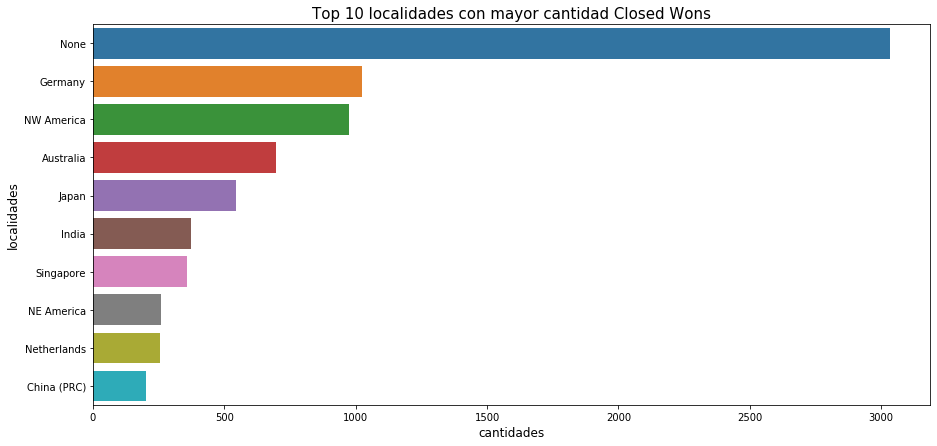

In [519]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_closed_won['number_of_closed_wons'], \
                y=df_closed_won.Territory, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad Closed Wons", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top_10_localidades_cw.png")

Top 10 localidades con mayor cantidad de oportunidades Closed Lost

In [520]:
df_closed_lost = df[df['Stage'] == 'Closed Lost']
df_closed_lost = df_closed_lost[df_closed_lost['Stage'] != None]
df_closed_lost = df_closed_lost.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_closed_lost = df_closed_lost.rename(columns={"Stage": "number_of_closed_lost"})
df_closed_lost = df_closed_lost.sort_values(by='number_of_closed_lost', ascending=False).head(10)
df_closed_lost

,Territory,number_of_closed_lost
46,None,1947
23,Germany,659
43,NW America,587
2,Australia,506
42,NE America,501
26,India,433
21,France,306
54,SE America,302
44,Netherlands,275
70,United Kingdom,191


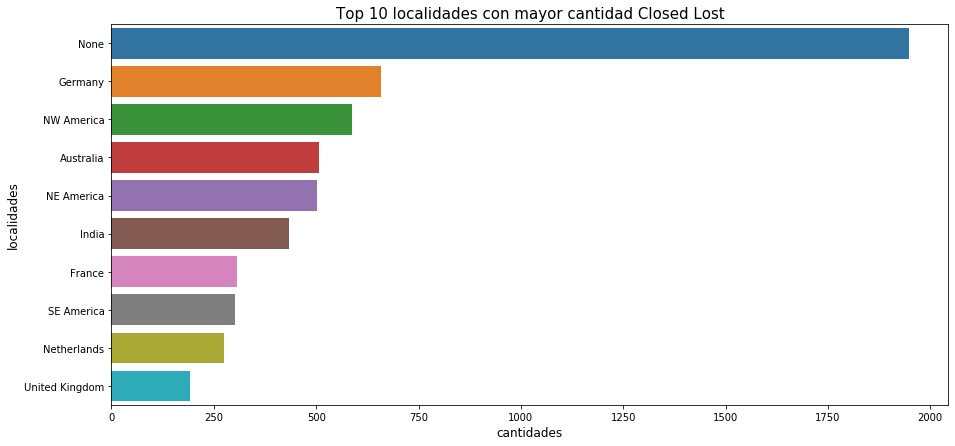

In [521]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_closed_lost['number_of_closed_lost'], \
                y=df_closed_lost.Territory, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad Closed Lost", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top_10_localidades_cl.png")

Top 10 localidades con mayor cantidad de oportunidades Negotiation (no llega a 10 hay que ponerle otro nombre)

In [522]:
df_negotiation = df[df['Stage'] == 'Negotiation']
df_negotiation = df_negotiation[df_negotiation['Stage'] != None]
df_negotiation = df_negotiation.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_negotiation = df_negotiation.rename(columns={"Stage": "number_of_negotiation"})
df_negotiation = df_negotiation.sort_values(by='number_of_negotiation', ascending=False).head(10)
df_negotiation

,Territory,number_of_negotiation
1,NW America,8
5,Saudi Arabia,5
0,Jordan,2
2,Netherlands,1
3,None,1
4,Oman,1


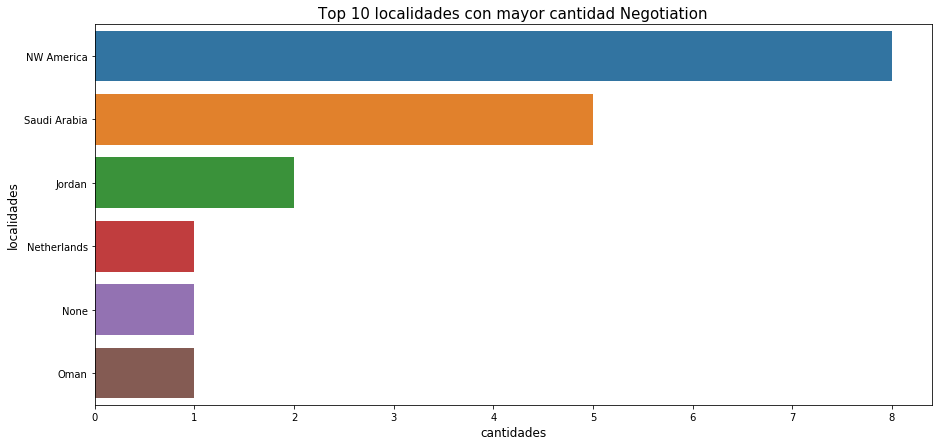

In [523]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_negotiation['number_of_negotiation'], \
                y=df_negotiation.Territory, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad Negotiation", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top_10_localidades_n.png")

Top 10 localidades con mayor cantidad de oportunidades Proposal

In [524]:
df_proposal = df[df['Stage'] == 'Proposal']
df_proposal = df_proposal[df_proposal['Stage'] != None]
df_proposal = df_proposal.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_proposal = df_proposal.rename(columns={"Stage": "number_of_proposal"})
df_proposal = df_proposal.sort_values(by='number_of_proposal', ascending=False).head(10)
df_proposal

,Territory,number_of_proposal
5,None,10
0,Australia,4
3,Japan,4
9,SE America,4
2,Indonesia,3
11,UAE (Dubai),3
4,Lebanon,2
1,India,1
6,Norway,1
7,Oman,1


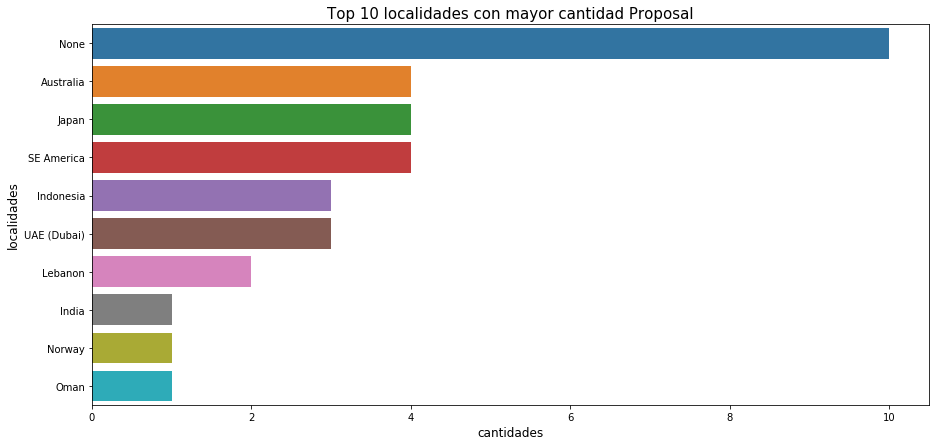

In [525]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_proposal['number_of_proposal'], \
                y=df_proposal.Territory, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad Proposal", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top_10_localidades_p.png")

Top 10 localidades con mayor cantidad de oportunidades Qualification (tambien son menos de 10)

In [526]:
df_qualification = df[df['Stage'] == 'Qualification']
df_qualification = df_qualification[df_qualification['Stage'] != None]
df_qualification = df_qualification.groupby('Territory').agg({"Stage":"count"}).reset_index()
df_qualification = df_qualification.rename(columns={"Stage": "number_of_qualification"})
df_qualification = df_qualification.sort_values(by='number_of_qualification', ascending=False).head(10)
df_qualification

,Territory,number_of_qualification
3,None,7
0,Australia,2
1,India,1
2,Japan,1


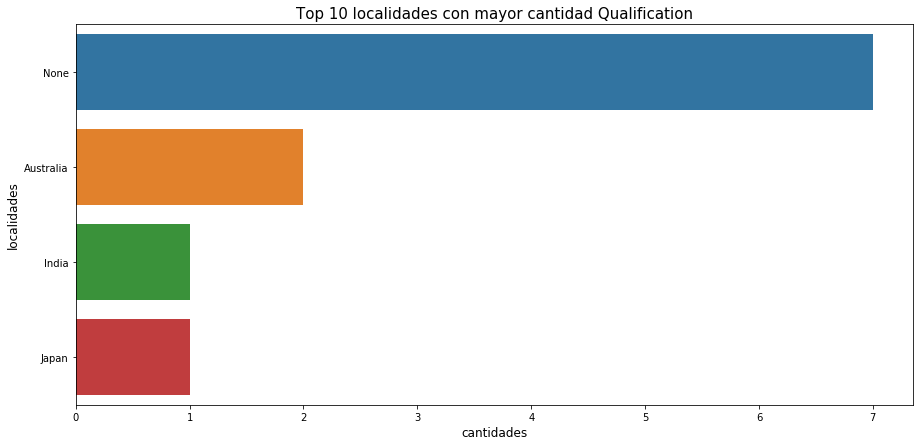

In [527]:
fig, ax = plt.subplots(figsize = (15, 7))
g = sns.barplot(x=df_qualification['number_of_qualification'], \
                y=df_qualification.Territory, orient='h',ax = ax,)
g.set_title("Top 10 localidades con mayor cantidad Qualification", fontsize=15)
g.set_xlabel("cantidades", fontsize=12)
g.set_ylabel("localidades", fontsize=12)
plt.savefig("top_10_localidades_q.png")

Cantidad de localidades por tipo de stage


In [528]:
df_stages = df[df['Stage'] == 'Closed Won']
df_stages = df[df['Stage'] != None]
df_stages = df_stages.groupby('Stage').agg({"Territory":"count"}).reset_index()
df_stages = df_stages.rename(columns={"Territory": "number_of_territories"})
df_stages

,Stage,number_of_territories
0,Closed Lost,7350
1,Closed Won,9533
2,Negotiation,18
3,Proposal,35
4,Qualification,11


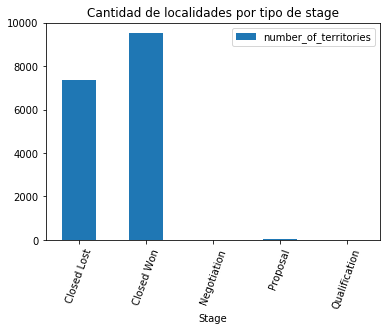

In [529]:
import matplotlib.pyplot as plot
df_stages.plot.bar(x="Stage", y="number_of_territories", rot=70, title="Cantidad de localidades por tipo de stage")
plot.show(block=True)

In [530]:
df.loc[:,["Territory","Region","Billing_Country"]].head(10)

,Territory,Region,Billing_Country
0,None,EMEA,Netherlands
1,None,EMEA,Netherlands
2,NW America,Americas,United States
3,NW America,Americas,United States
4,NW America,Americas,United States
5,NW America,Americas,United States
6,NW America,Americas,United States
7,NW America,Americas,United States
8,None,Japan,Japan
9,None,Japan,Japan


In [531]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [532]:
#agrego singapore que no esta en el df world
singapore = gpd.read_file('Maps/Singapore_AL2-AL2.shp')
singapore = singapore.loc[:,["name","country","geometry"]]
singapore.columns = ["name","iso_a3","geometry"]
singapore["continent"] = "Asia"
#world = world.append(singapore,ignore_index = True)
world[world["name"].str.contains("R")]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.340 -4.500, 29.520 -5.420, 29.420..."
17,10734247,North America,Dominican Rep.,DOM,161900.0,"POLYGON ((-71.708 18.045, -71.688 18.317, -71...."
18,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((178.725 71.099, 180.000 71.516..."
34,4930258,North America,Costa Rica,CRI,79260.0,"POLYGON ((-82.546 9.566, -82.933 9.477, -82.92..."
45,3351827,North America,Puerto Rico,PRI,131000.0,"POLYGON ((-66.282 18.515, -65.771 18.427, -65...."
66,5625118,Africa,Central African Rep.,CAF,3206.0,"POLYGON ((27.374 5.234, 27.044 5.128, 26.403 5..."
117,21529967,Europe,Romania,ROU,441000.0,"POLYGON ((28.234 45.488, 28.680 45.304, 29.150..."
169,11901484,Africa,Rwanda,RWA,21970.0,"POLYGON ((30.419 -1.135, 30.816 -1.699, 30.758..."


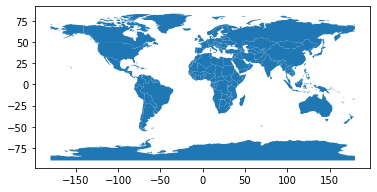

In [533]:
world.plot()
plt.show()

In [534]:
#acomodar datos de geo para permitir el merge con world
df_geo = df.loc[:,["Opportunity_Name","Billing_Country","Territory","Region"]]
df_geo['Billing_Country'] = df_geo['Billing_Country'].fillna(df['Territory'])
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("United States", "United States of America")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Republic of", "South Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Democratic People's Republic of", "North Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Reunion", "France")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Macedonia, the former Yugoslav Republic of", "Macedonia")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Bosnia and Herzegovina", "Bosnia and Herz.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Dominican Republic", "Dominican Rep.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Viet Nam", "Vietnam")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Czech Republic", "Czechia")
df_geo = df_geo.groupby("Billing_Country").agg({"Opportunity_Name":"count"})
df_geo = df_geo.rename(columns={"Opportunity_Name":"count"})
df_geo

,count
Billing_Country,
Albania,2
Argentina,1
Armenia,2
Australia,1169
Austria,145
...,...
Turkey,17
United Arab Emirates,41
United Kingdom,284


In [543]:
dfmerge = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge['count_log'] = np.log(dfmerge['count'])
dfmerge["count"] = dfmerge["count"].fillna(0)
dfmerge["count_log"] = dfmerge["count_log"].fillna(0)
dfmerge.nlargest(10,"count")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,count,count_log
155,126451398,Asia,Japan,JPN,4932000.0,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",4879.0,8.492696
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3802.0,8.243283
121,80594017,Europe,Germany,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",1979.0,7.590347
137,23232413,Oceania,Australia,AUS,1189000.0,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907...",1169.0,7.063904
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",672.0,6.510258
130,17084719,Europe,Netherlands,NLD,870800.0,"POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...",563.0,6.333280
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",398.0,5.986452
132,48958159,Europe,Spain,ESP,1690000.0,"POLYGON ((-7.45373 37.09779, -7.53711 37.42890...",317.0,5.758902
141,62137802,Europe,Italy,ITA,2221000.0,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",295.0,5.686975
143,64769452,Europe,United Kingdom,GBR,2788000.0,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",284.0,5.648974


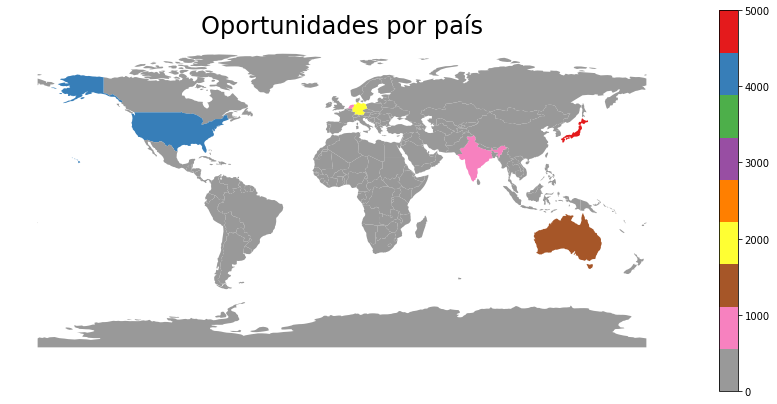

In [544]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por país',size=24)
sm = plt.cm.ScalarMappable(cmap='Set1_r', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)
dfmerge.plot(column='count',cmap='Set1_r',ax=ax)

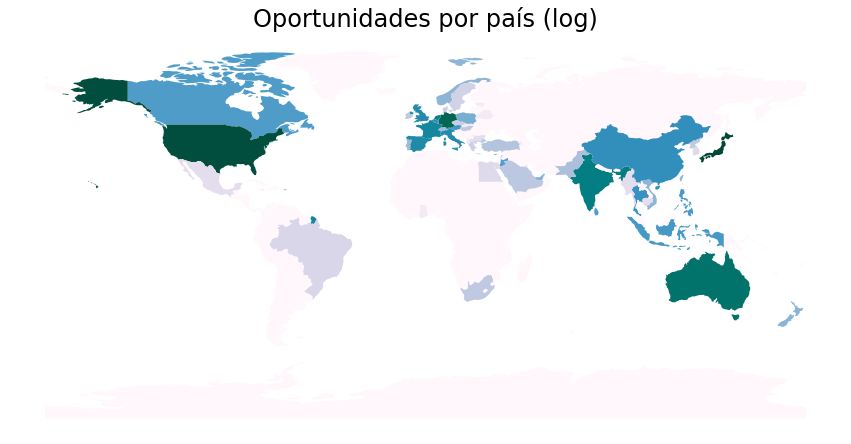

In [547]:
fig, ax = plt.subplots(1, figsize=(15, 9))
ax.axis('off')
plt.title('Oportunidades por país (log)',size=24)
dfmerge.plot(column='count_log',cmap='PuBuGn',ax=ax)